In [1]:
import numpy as np
import cPickle as pickle

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms

from matplotlib.ticker import NullFormatter, ScalarFormatter, NullLocator, AutoLocator, MultipleLocator

class SqrtScale(mscale.ScaleBase):
    # The name under which this scale will be registered with matplotlib.
    name = 'sqrt'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self)

    def get_transform(self):
        return self.SqrtTransform()

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(AutoLocator())
        axis.set_major_formatter(ScalarFormatter())
        axis.set_minor_locator(NullLocator())
        axis.set_minor_formatter(NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return max(vmin, 0.0), vmax

    class SqrtTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def __init__(self):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            masked = np.ma.masked_where((a < 0.0), a)
            if masked.mask.any():
                return ma.sqrt(masked)
            else:
                return np.sqrt(a)

        def inverted(self):
            return SqrtScale.InvertedSqrtTransform()

    class InvertedSqrtTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def __init__(self):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            return a**2

        def inverted(self):
            return SqrtScale.SqrtTransform()

mscale.register_scale(SqrtScale)

def plot_regret_curves(ax, info, regret, xscale=None, yscale=None):
    ranker_model_name = info['ranking_model'].getName()
    click_model_name = info['click_model'].getName()
    cutoff = info['cutoff']
    qid = info['query']
    regret = regret.cumsum()
    
    xscale = 'linear' if xscale is None else xscale
    yscale = 'linear' if yscale is None else yscale
    
    # Subsample regret if there is more than 10^5 iterations.
    if regret.shape[0] > 100000:
        indices = np.linspace(0, regret.shape[0] - 1, 100000).astype('int32')
        regret = regret[indices]
    else:
        indices = np.arange(regret.shape[0], dtype='int32')

    ax.set_title('%s - %s@%d - Q%s (%s Regret Plot)' % (ranker_model_name, click_model_name, cutoff, qid,
                                                       xscale.capitalize()  + '-' + yscale.capitalize()))

    ax.plot(indices, regret, 'b-')

    ax.set_ylabel('Regret - (CTR@%d)' % cutoff)
    ax.set_xlabel('Impressions')

    ax.set_xscale(xscale)
    ax.set_yscale(yscale)

    ax.title.set_fontsize(10)

    ax.xaxis.label.set_fontsize(10)
    ax.yaxis.label.set_fontsize(10)

    ax.xaxis.get_offset_text().set_fontsize(10)
    ax.yaxis.get_offset_text().set_fontsize(10)

    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)

with open('data/model_query_collection.pkl') as ifile:
    MQD = pickle.load(ifile)

# Cumulative Regret Curves for Ranking and Click Model Pairs

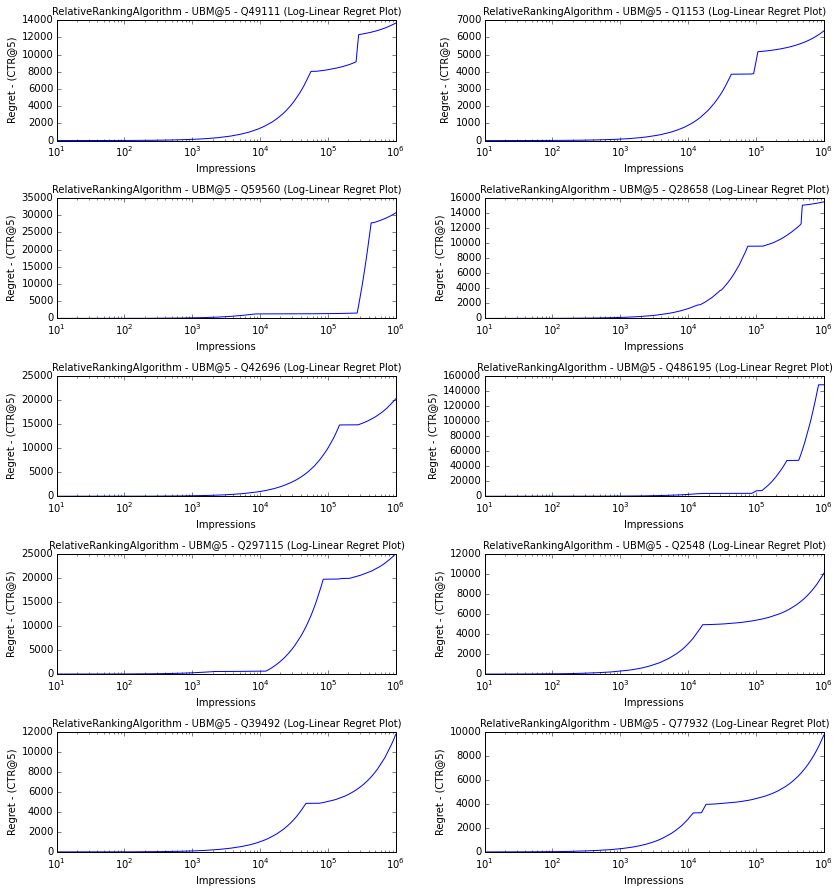

In [2]:
import os
import cPickle as pickle
from ipywidgets import Select, Dropdown, interactive, HBox
from IPython.display import display

def get_regret_filepath(experiment_info_filepath):
    return experiment_info_filepath.rstrip('experiment.nfo') + 'regret.npy'

def show_regrets_widget():
    experiment_filepaths = []
    experiment_specs = []
    
    def show_regrets(ranking_model_name, click_model_name, xscale, yscale):
        spec_indices = [i for i, spec in enumerate(experiment_specs)
                        if spec['click_model'].getName() == click_model_name and
                        spec['ranking_model'].getName() == ranking_model_name and
                        os.path.exists(get_regret_filepath(experiment_filepaths[i]))]
        
        specs = [experiment_specs[i] for i in spec_indices]
        regrets = [np.load(get_regret_filepath(experiment_filepaths[i])) for i in spec_indices]

        n_rows = len(specs) / 2
        n_cols = 2 if len(specs) > 1 else 1
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 2.5 * n_rows))
        
        axes = axes.ravel()
        
        for ax, info, regret in zip(axes, specs, regrets):
            plot_regret_curves(ax, info, regret, xscale=xscale, yscale=yscale)
        plt.tight_layout()
        plt.show()   

    for root, dirs, files in os.walk("experiments", topdown=True):
        for fn in files:
            if fn.endswith('.nfo'):
                fp = os.path.join(root, fn)
                experiment_filepaths.append(fp)
                with open(fp) as ifile:
                    experiment_specs.append(pickle.load(ifile))
    
    ranking_model_names = set([spec['ranking_model'].getName() for spec in experiment_specs])
    click_model_names = set([spec['click_model'].getName() for spec in experiment_specs])

    rmdd = Select(options=list(ranking_model_names), description='Ranking Model:', width='150px')
    cmdd = Select(options=list(click_model_names), description='Click Model:', width='75px')
    xsdd = Select(options=['linear', 'sqrt', 'log'], description='X Scale:', width='100px')
    ysdd = Select(options=['linear', 'sqrt', 'log'], description='Y Scale:', width='100px')
    
    controls = HBox([rmdd, cmdd, xsdd, ysdd])
    backend = interactive(show_regrets, ranking_model_name=rmdd, click_model_name=cmdd,
                          xscale=xsdd, yscale=ysdd)

    controls.on_displayed(lambda _: show_regrets(rmdd.value, cmdd.value, xsdd.value, ysdd.value))

    display(controls)

show_regrets_widget()

# Cumulative Regret Curves for Ranking and Click Model Pairs

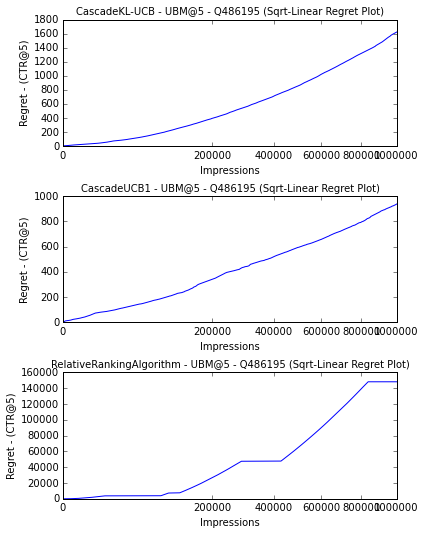

In [8]:
import os
import cPickle as pickle
from ipywidgets import Select, Dropdown, interactive, HBox
from IPython.display import display

def get_regret_filepath(experiment_info_filepath):
    return experiment_info_filepath.rstrip('experiment.nfo') + 'regret.npy'

def show_regrets_widget():
    experiment_filepaths = []
    experiment_specs = []
    
    def show_regrets(query, click_model_name, xscale, yscale):
        spec_indices = [i for i, spec in enumerate(experiment_specs)
                        if spec['click_model'].getName() == click_model_name and
                        spec['query'] == query and
                        os.path.exists(get_regret_filepath(experiment_filepaths[i]))]
        
        specs = [experiment_specs[i] for i in spec_indices]
        regrets = [np.load(get_regret_filepath(experiment_filepaths[i])) for i in spec_indices]

        n_rows = len(specs)
        n_cols = 1 #2 if len(specs) > 1 else 1
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 2.5 * n_rows))
        
        axes = axes.ravel()
        
        for ax, info, regret in zip(axes, specs, regrets):
            plot_regret_curves(ax, info, regret, xscale=xscale, yscale=yscale)
        plt.tight_layout()
        plt.show()   

    for root, dirs, files in os.walk("experiments", topdown=True):
        for fn in files:
            if fn.endswith('.nfo'):
                fp = os.path.join(root, fn)
                experiment_filepaths.append(fp)
                with open(fp) as ifile:
                    experiment_specs.append(pickle.load(ifile))
    
    queries = set([spec['query'] for spec in experiment_specs])
    click_model_names = set([spec['click_model'].getName() for spec in experiment_specs])

    qdd = Select(options=list(queries), description='Queries:', width='150px')
    cmdd = Select(options=list(click_model_names), description='Click Model:', width='75px')
    xsdd = Select(options=['linear', 'sqrt', 'log'], description='X Scale:', width='100px')
    ysdd = Select(options=['linear', 'sqrt', 'log'], description='Y Scale:', width='100px')
    
    controls = HBox([qdd, cmdd, xsdd, ysdd])
    backend = interactive(show_regrets, query=qdd, click_model_name=cmdd, xscale=xsdd, yscale=ysdd)

    controls.on_displayed(lambda _: show_regrets(qdd.value, cmdd.value, xsdd.value, ysdd.value))

    display(controls)

show_regrets_widget()

In [11]:
Imps = np.load('experiments/RelativeRankingAlgorithm_Horizon1000000/RelativeRankingAlgorithm_UBM_486195_5_1000000_rankings.npy')
print Imps[999:20000:1000,:]
print MQD['UBM']['486195']['model'].get_ideal_ranking()
print MQD['UBM']['486195']['model'].get_ideal_ranking(cutoff=5)

[[0 6 5 4 3 8 9 2 1 7]
 [3 2 9 7 6 4 0 5 8 1]
 [7 4 2 8 0 6 9 1 3 5]
 [1 9 8 3 2 5 7 4 0 6]
 [0 9 1 3 8 5 2 7 6 4]
 [6 8 3 0 5 2 1 4 7 9]
 [2 1 9 0 5 3 8 6 7 4]
 [1 8 6 9 0 4 5 3 2 7]
 [0 8 5 1 9 4 2 3 6 7]
 [6 0 3 9 2 8 1 7 5 4]
 [8 0 9 2 4 1 6 3 5 7]
 [3 5 2 1 0 4 7 8 9 6]
 [7 6 4 8 2 3 5 9 1 0]
 [0 2 4 7 5 8 3 1 6 9]
 [1 9 3 5 6 8 0 2 4 7]
 [0 3 1 4 6 5 6 7 8 9]
 [0 3 1 4 6 5 6 7 8 9]
 [0 3 1 4 6 5 6 7 8 9]
 [0 3 1 4 6 5 6 7 8 9]
 [0 3 1 4 6 5 6 7 8 9]]
[0 3 1 6 5 4 2 9 8 7]
[0 3 1 6 5]
